In [1]:
import os
from PIL import Image,ImageOps,ImageDraw
import numpy as np
from scipy import sqrt
import scipy.io as sio
import cv2 as cv
from utils.preprocessing import *
from utils.loadData import *

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
class model_parameters(object):
    
    def __init__(self,
                 iterNum = 5,
                 alpha = 1,
                 new_size = (400,400),
                 expand = 50,
                 expand_rate = 0.25,
                 train_or_test = 'train',
                 dataset = 'helen',
                 demo = False):
        self.iterNum = iterNum
        self.alpha = alpha
        self.new_size = new_size
        self.expand =expand
        self.expand_rate = expand_rate
        self.train_or_test = train_or_test
        self.dataset = dataset
        self.demo = demo
        
    def show_parameters(self):
        print('dataset:',self.dataset)
        print('use data in trainset or testset:',self.train_or_test)
        print('the number of iterations:',self.iterNum)
        print('the L1 regularization parameter alpha is:',self.alpha)
        print('the new image size used is:',self.new_size)
        print('how much to expand in data preparation:',self.expand)
        print('the rate of expand in modifing the bbox:',self.expand_rate)

In [3]:
# def get_images_names(parameters):
#     '''
#     get a list containing all the paths of images in the trainset
#     ---------------------------------------------------------------------------
#     INPUT:
#         parameters: model parameter object
#     OUTPUT:
#         a list with all the images' names, including extension
#     ---------------------------------------------------------------------------
#     '''
#     folder_path = parameters.dataset + '/' + parameters.train_or_test + 'set/imgs'
#     assert os.path.exists(folder_path)
#     assert os.path.isdir(folder_path)
#     imageNames = os.listdir(folder_path)
#     return imageNames

In [4]:
# def load_boxes(parameters):
# # just some ugly translations from the very nested MATLAB representation of the bbox information
#     bboxes1 = sio.loadmat(parameters.dataset + '/bounding_boxes_' +parameters.dataset 
#                           + '_'+parameters.train_or_test +'set.mat')['bounding_boxes']
#     ret = {}
#     for bb in bboxes1[0]:
#         ret[bb[0][0][0][0]] = list(bb[0][0][1][0])
#     return ret

In [5]:
# def load_landmarks(image_name,parameters):
#     '''
#     load the landmarks coordinates from .pts file
#     ---------------------------------------------------------------------------
#     INPUT:
#         image_name: a string with extension   ex: 'image_0122.png'
#         parameters: model parameter object
#     OUTPUT:
#         a numpy array containing all the points
#     ---------------------------------------------------------------------------
#     '''    
#     file_path = parameters.dataset + '/' + parameters.train_or_test + 'set/pts/' + image_name[:-4] +'.pts'  
#     assert os.path.exists(file_path)
#     with open(file_path) as f: 
#         rows = [rows.strip() for rows in f]
#     coords_set = [point.split() for point in rows[rows.index('{') + 1:rows.index('}')]]
#     return np.array([list([float(point) for point in coords]) for coords in coords_set])

In [6]:
# def expand_bbox(image_size,bbox,parameters):
#     '''
#     compute the expanded bbox
#     a robust function to expand the crop image bbox even the original bbox is
#     around the border of the image
#     ---------------------------------------------------------------------------
#     INPUT:
#         image_size: a tuple   ex: (height,width)
#         bbox: the ground_truth bounding boxes  ex:[x0,y0,x1,y1]
#         parameters: model parameter object
#     OUTPUT:
#         new bbox: ex:[x0,y0,x1,y1]
#     ---------------------------------------------------------------------------
#     '''
#     x_size,y_size = image_size
#     bx0,by0,bx1,by1 = bbox
#     bw = by1 - by0
#     bh = bx1 - bx0
#     if bw > bh:
#         delta = parameters.expand_rate * bw
#         if by1 + delta > y_size:
#             new_by1 = y_size
#         else:
#             new_by1 = int(floor(by1 + delta))
#         if by0 - delta < 0:
#             new_by0 = 0
#         else:
#             new_by0 = int(floor(by0 - delta))
#         new_w = new_by1 - new_by0
#         delta_h = (new_w - bh) / 2
#         if bx0 - delta_h < 0:
#             new_bx0 = 0
#         else:
#             new_bx0 = int(floor(bx0 - delta_h))
#         if bx1 + delta_h > x_size:
#             new_bx1 = x_size
#         else:
#             new_bx1 = int(floor(bx1 + delta_h))
#     else:
#         delta = parameters.expand_rate * bh
#         if bx1 + delta > x_size:
#             new_bx1 = x_size
#         else:
#             new_bx1 = int(floor(bx1 + delta))
#         if bx0 - delta < 0:
#             new_bx0 = 0
#         else:
#             new_bx0 = int(floor(bx0 - delta))
#         new_h = new_bx1 - new_bx0
#         delta_w = (new_h - bw) / 2
#         if by0 - delta_w < 0:
#             new_by0 = 0
#         else:
#             new_by0 = int(floor(by0 - delta_w))
#         if by1 + delta_w > y_size:
#             new_by1 = y_size
#         else:
#             new_by1 = int(floor(by1 + delta_w))
#     return new_bx0,new_by0,new_bx1,new_by1

In [7]:
# def crop_and_resize_image(image_name,bbox,parameters):
#     '''
#     crop and resize the image given the ground truth bounding boxes
#     also, compute the new coordinates according to transformation
#     ---------------------------------------------------------------------------
#     INPUT:
#         image_name: a string without extension  ex: 'image_0007'
#         bbox: the ground_truth bounding boxes  ex:[x0,y0,x1,y1]
#         parameters: model parameter object
#     OUTPUT:
#         grey: a numpy array of grey image after crop and resize
#         landmarks: new landmarks accordance with new image
#     ---------------------------------------------------------------------------
#     '''
#     image_path = parameters.dataset + '/' + parameters.train_or_test + 'set/imgs/' + image_name
#     print(image_path)
#     assert os.path.exists(image_path)
#     im = Image.open(image_path)
#     bbox = expand_bbox(im.size,bbox,parameters)
#     im_crop = im.crop(bbox)
#     Expand = parameters.expand
#     im_expand = ImageOps.expand(im_crop,(Expand,Expand,Expand,Expand),fill = 'black')
#     im_resize = im_expand.resize(parameters.new_size)
    
#     #compute the new landmarks according to transformation procedure
#     landmarks = load_landmarks(image_name,parameters)
#     landmarks = landmarks - (bbox[:2]) + Expand
#     landmarks = landmarks * im_resize.size / im_expand.size
    
#     return np.array(im_resize),landmarks.astype(int)

In [3]:
def get_hog_features(im, locations):
    winSize = (16,16) #(32,32)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                           histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    winStride = (8,8)
    padding = (8,8)
    if isinstance(locations, np.ndarray): 
        locations = [tuple(lc.tolist()) for lc in locations]
        locations = tuple(locations)
    hog_feat = hog.compute(im,winStride,padding,locations)
    hog_feat = hog_feat.reshape(-1)
    return hog_feat 

In [4]:
def crop_images_and_get_GT_data(parameters):
    #get the image path list
    image_names_list = get_images_names(parameters)

    #get the ground truth bounding boxes
    bbox_dict = load_boxes(parameters)

    #compute the hog features of ture landmarks
    landmarks_list = []
    hog_list = []
    cropped_im_list = []
    print('cropping and computing the hog features for ture landmarks...........')

    for img in image_names_list:
        cropped_im,landmarks = crop_and_resize_image(img,bbox_dict[img],parameters)
        hog_list.append(get_hog_features(cropped_im,landmarks))
        cropped_im_list.append(cropped_im)
        landmarks_list.append(landmarks.reshape(-1))
    
    print('done cropping and computing the hog features for ture landmarks')
    
    true_hog = np.array(hog_list)
    true_landmarks = np.array(landmarks_list)

    #compute the initial landmarks by mean
    initial_landmarks = np.mean(true_landmarks,axis = 0).astype(int)
    x_k = np.array([initial_landmarks.tolist()] * len(image_names_list))
    initial_landmarks = initial_landmarks.reshape(68,2)
    
    return cropped_im_list, true_hog, true_landmarks, initial_landmarks






Cross validation to find the best alpha

In [46]:
def train(cropped_im_list, true_hog, true_landmarks, alpha, initial_landmarks, parameters):
    
    HOG_x_k = np.zeros((true_hog.shape[0],true_hog.shape[1]+1))
    x_k = np.array([initial_landmarks.reshape(-1).tolist()] * len(cropped_im_list))
    W = []
    #cascade linear regression
    for k in range(parameters.iterNum):

        print('Iteration: ',k + 1)
        # get features 
        for j in range(len(cropped_im_list)):
            HOG_x_k[j,:-1] = get_hog_features(cropped_im_list[j], x_k[j,:].reshape(68,2))
            HOG_x_k[j,-1] = 1 # inserting the bias into the W matrix

        #compute the delta x
        delta_x = true_landmarks - x_k

        # calculate W_tilda for the k-th iteration (W=[R; b])
        inv_expression = np.linalg.inv(np.matmul(HOG_x_k.T,HOG_x_k)+alpha*np.identity(HOG_x_k.shape[1]))
        W_k = np.matmul(np.matmul(inv_expression,HOG_x_k.T),delta_x)

        #update new landmarks        
        x_k = x_k + np.matmul(HOG_x_k, W_k)
        print('RMSE error is ', sqrt((abs(x_k.astype(int) - true_landmarks)**2).sum() / len(true_landmarks)))
        W.append(W_k) 
    return W


In [32]:
def train_for_differnt_alphas(cropped_im_list, true_hog, true_landmarks, alpha_vec, initial_landmarks, parameters):    
    W_dict = {}
    
    for alpha in alpha_vec:
        #training
        print('alpha = ', alpha)
        W = train(cropped_im_list, true_hog, true_landmarks, alpha, initial_landmarks, parameters)  

        W_dict[alpha] = np.array(W)
        print('woohoo!!')
    
    
    return W_dict
    
    

In [10]:
#crop all train images according to bounding boxes
parameters = model_parameters()
parameters.train_or_test = 'train'
cropped_im_list, true_hog, true_landmarks, initial_landmarks = crop_images_and_get_GT_data(parameters)

computing the hog features for ture landmarks...........
helen/trainset/imgs/2898498038_3.jpg
helen/trainset/imgs/2560341685_1.jpg
helen/trainset/imgs/2699422785_1.jpg
helen/trainset/imgs/279233131_1.jpg
helen/trainset/imgs/1405372343_1.jpg
helen/trainset/imgs/173744986_1.jpg
helen/trainset/imgs/2662367038_1.jpg
helen/trainset/imgs/2070634156_1.jpg
helen/trainset/imgs/2571808206_1.jpg
helen/trainset/imgs/2782810504_1.jpg
helen/trainset/imgs/2498590482_1.jpg
helen/trainset/imgs/2794931589_1.jpg
helen/trainset/imgs/2355774121_1.jpg
helen/trainset/imgs/2084520102_1.jpg
helen/trainset/imgs/1125456779_1.jpg
helen/trainset/imgs/20301003_1.jpg
helen/trainset/imgs/2175042512_1.jpg
helen/trainset/imgs/1436253170_1.jpg
helen/trainset/imgs/2931219937_1.jpg
helen/trainset/imgs/2815405614_1.jpg
helen/trainset/imgs/2246883372_1.jpg
helen/trainset/imgs/2414075021_1.jpg
helen/trainset/imgs/129408727_1.jpg
helen/trainset/imgs/1111575413_1.jpg
helen/trainset/imgs/2595847708_1.jpg
helen/trainset/imgs/262

In [78]:
# calculate W values for different alphas
alpha_vec = [1, 2, 4, 8, 16, 24, 32, 48]
W_dict = train_for_differnt_alphas(cropped_im_list, true_hog, true_landmarks, alpha_vec, initial_landmarks, parameters)


alpha =  1
Iteration:  1
RMSE error is  69.77542905636625
Iteration:  2
RMSE error is  23.309847704350194
Iteration:  3
RMSE error is  11.926357365096855
Iteration:  4
RMSE error is  9.288460582895317
Iteration:  5
RMSE error is  8.60502760018816
woohoo!!
alpha =  2
Iteration:  1
RMSE error is  83.78913115673177
Iteration:  2
RMSE error is  33.40511188426107
Iteration:  3
RMSE error is  17.501385659427083
Iteration:  4
RMSE error is  12.553883861180172
Iteration:  5
RMSE error is  10.637574911604618
woohoo!!
alpha =  4
Iteration:  1
RMSE error is  98.08614326193073
Iteration:  2
RMSE error is  45.7328875099747
Iteration:  3
RMSE error is  25.97428536071782
Iteration:  4
RMSE error is  18.44121742185152
Iteration:  5
RMSE error is  15.13657821305727
woohoo!!
alpha =  8
Iteration:  1
RMSE error is  112.162669814872
Iteration:  2
RMSE error is  60.51913333814357
Iteration:  3
RMSE error is  38.03620643544779
Iteration:  4
RMSE error is  27.726638815406385
Iteration:  5
RMSE error is  22.7

In [82]:
# load lists of validation and test images
# the test set of 330 images is divided to validation and test
parameters.train_or_test = 'test'
image_names_valtest_list = get_images_names(parameters)
val_image_names = image_names_valtest_list[:int(len(image_names_valtest_list)/2)]
test_image_names = image_names_valtest_list[int(len(image_names_valtest_list)/2):]


In [49]:
def RMSE_of_alphas(alpha_vec, W_dict, val_image_names, parameters, initial_landmarks):
    parameters.demo = False
    parameters.train_or_test = 'test'
    bbox_dict = load_boxes(parameters)
    RMSE_dict = {}
    for alpha in alpha_vec:
        RMSE_dict[alpha] = []
        
    for val_im in val_image_names:
        cropped_im_val,mark_true = crop_and_resize_image(val_im,bbox_dict[val_im],parameters)
        
        for alpha in alpha_vec:
            mark_x = initial_landmarks.astype(float) # initialize landmarks locations
            for i in range(W_dict[alpha].shape[0]):
                HOG_x_k = get_hog_features(cropped_im_val,mark_x)
                HOG_x_k = np.append(HOG_x_k,[[1]])
                mark_x = (mark_x.reshape(-1) + np.matmul(HOG_x_k, W_dict[alpha][i]).astype(float)).reshape(68,2)
            # calculate the rms error after the final update
            rmse_temp = (sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
            RMSE_dict[alpha].append(rmse_temp)
    return RMSE_dict

In [123]:
def test_one_image(W,img_name,bbox,initials,parameters):
    '''
    given the regressors, predicted the landmarks
    ---------------------------------------------------------------------------
    INPUT:
        R: the R matrix
        b: the b vector
        path: the image file name with extension
        bbox: the numpy array of bbox
        initials: the numpy array of initials landmarks
        parameters: model parameter object
    OUTPUT:
        mark_x: predicted landmarks
        mark_t: the true landmarks
        MSE: the mean square error of all the iterations
    ---------------------------------------------------------------------------
    '''
    parameters.train_or_test = 'test'                       
                           
    cropped_im,mark_true = crop_and_resize_image(img_name,bbox,parameters, print_image_path=True)
    mark_x = initials.astype(float)
    RMSE = []
    
    for i in range(W.shape[0]):
        HOG_x_k = get_hog_features(cropped_im,mark_x)
        HOG_x_k = np.append(HOG_x_k,[[1]])
        mark_x = (mark_x.reshape(-1) + np.matmul(HOG_x_k, W[i]).astype(float)).reshape(68,2)
        RMSE.append(sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
        
    if parameters.demo:
        img = Image.fromarray(cropped_im)
        draw = ImageDraw.Draw(img)
        width = 2
        for i in range(len(mark_x)):
            circle = [mark_x[i,0]-width,mark_x[i,1]-width,mark_x[i,0]+width,mark_x[i,1]+width]
            draw.ellipse(circle,fill = 'red')
#         img = cv.imread(parameters.dataset + '/' + parameters.train_or_test + 'set/imgs/' + img_name)
#         img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#         for landmark in mark_x:
#             landmark = [int(i) for i in landmark]
#             cv.circle(img,tuple(landmark), 10, (255,0,0), -1)
        
        plt.imshow(img)
        print('RMSE for this image is ', RMSE[-1])
    return mark_x.astype(int),mark_true,RMSE

In [79]:
# calculate the RMS error on the val set for different alphas, and chose the best alpha
RMSE_dict = RMSE_of_alphas(alpha_vec, W_dict, val_image_names, parameters, initial_landmarks)
median_err = 1000
chosen_alpha = 0
for key in RMSE_dict:
    print('alpha =', key)
    print('mean RMSE = ', np.mean(RMSE_dict[key]))
    print('median RMSE = ', np.median(RMSE_dict[key]))
    if np.median(RMSE_dict[key]) < median_err:
        chosen_alpha = key
        median_err = np.median(RMSE_dict[key])
parameters.alpha = chosen_alpha
print('chosen alpha is ', chosen_alpha)

helen/testset/imgs/3071735588_1.jpg
helen/testset/imgs/2993039649_1.jpg
helen/testset/imgs/3161007246_1.jpg
helen/testset/imgs/3220050079_2.jpg
helen/testset/imgs/3211768569_1.jpg
helen/testset/imgs/3201451573_1.jpg
helen/testset/imgs/2984478058_1.jpg
helen/testset/imgs/3045005984_1.jpg
helen/testset/imgs/3166996956_1.jpg
helen/testset/imgs/3234996955_1.jpg
helen/testset/imgs/3168247070_1.jpg
helen/testset/imgs/305612849_1.jpg
helen/testset/imgs/3029583659_1.jpg
helen/testset/imgs/302142529_1.jpg
helen/testset/imgs/307494478_1.jpg
helen/testset/imgs/3214066418_2.jpg
helen/testset/imgs/3057639344_1.jpg
helen/testset/imgs/2986008801_1.jpg
helen/testset/imgs/2988554491_2.jpg
helen/testset/imgs/3059991235_1.jpg
helen/testset/imgs/2982058191_1.jpg
helen/testset/imgs/3025229116_1.jpg
helen/testset/imgs/2971848745_1.jpg
helen/testset/imgs/3213087169_2.jpg
helen/testset/imgs/2985256877_1.jpg
helen/testset/imgs/30427236_1.jpg
helen/testset/imgs/3213270807_4.jpg
helen/testset/imgs/3218864820_1.j

In [81]:
median_err = 1000
chosen_alpha = 0
for key in RMSE_dict:
    print('alpha =', key)
    print('mean RMSE = ', np.mean(RMSE_dict[key]))
    print('median RMSE = ', np.median(RMSE_dict[key]))
    if np.median(RMSE_dict[key]) < median_err:
        chosen_alpha = key
        median_err = np.median(RMSE_dict[key])
parameters.alpha = chosen_alpha
print('chosen alpha is ', chosen_alpha)

alpha = 16
mean RMSE =  10.798110309433538
median RMSE =  9.174773598745382
alpha = 1
mean RMSE =  18.203194270144067
median RMSE =  16.376543483610583
alpha = 2
mean RMSE =  15.939586529366947
median RMSE =  14.204908016763287
alpha = 4
mean RMSE =  13.661367840260247
median RMSE =  11.852028865780497
alpha = 48
mean RMSE =  10.05743255428182
median RMSE =  8.152949664709952
alpha = 24
mean RMSE =  10.416401922410172
median RMSE =  8.698377130584896
alpha = 32
mean RMSE =  10.193652815017078
median RMSE =  8.385912556887575
alpha = 8
mean RMSE =  11.990896754744695
median RMSE =  10.564925321970977
chosen alpha is  48


In [86]:
def test(W, test_image_names, parameters, initial_landmarks):
    parameters.demo = False
    parameters.train_or_test = 'test'
    bbox_dict = load_boxes(parameters)
    RMSE_test = []
        
    for test_im in test_image_names:
        cropped_im_val,mark_true = crop_and_resize_image(test_im,bbox_dict[test_im],parameters)
        mark_x = initial_landmarks.astype(float) # initialize landmarks locations
        for i in range(W.shape[0]):
            HOG_x_k = get_hog_features(cropped_im_val,mark_x)
            HOG_x_k = np.append(HOG_x_k,[[1]])
            mark_x = (mark_x.reshape(-1) + np.matmul(HOG_x_k, W[i]).astype(float)).reshape(68,2)
        # calculate the rms error after the final update
        rmse_temp = (sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
        RMSE_test.append(rmse_temp)
    return RMSE_test

In [88]:
# test
RMSE_test = test(W_dict[parameters.alpha], test_image_names, parameters, initial_landmarks)
print('mean RMSE on test set = ', np.mean(RMSE_test))
print('median RMSE on test set = ', np.median(RMSE_test))

mean RMSE on test set =  10.041860874206844
median RMSE on test set =  8.123133269720931


## Let's see some examples!

### Good examples

helen/testset/imgs/30427236_2.jpg
RMSE for this image is  4.571330093477107


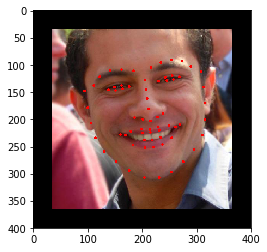

In [186]:
bbox_dict = load_boxes(parameters)
parameters.demo = True
n=29
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/323855036_4.jpg
RMSE for this image is  4.5


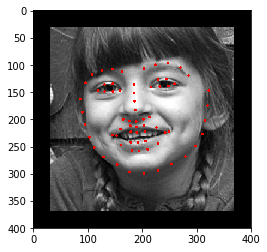

In [125]:
n = 18
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3213214947_2.jpg
RMSE for this image is  5.3591592843741935


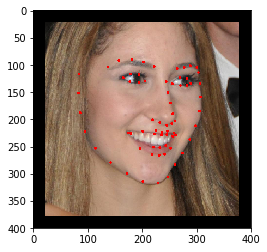

In [147]:
n = 64
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

### Bad examples

helen/testset/imgs/3213825562_1.jpg
RMSE for this image is  84.95405332572771


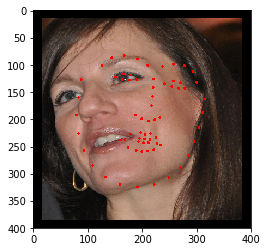

In [126]:
n=102
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3051542838_1.jpg
RMSE for this image is  30.244348037861457


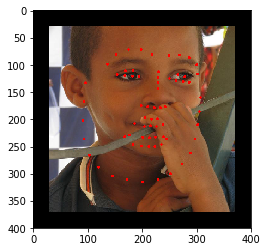

In [172]:
n=87
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3006823882_1.jpg
RMSE for this image is  17.77059699748601


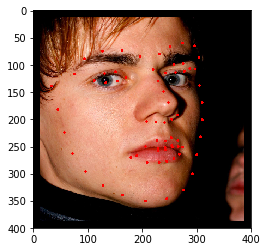

In [137]:
n=134
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

In [21]:
# # def train():
parameters = model_parameters()
parameters.train_or_test = 'train'
    
#show the parameters which will be used
parameters.show_parameters()
    
#get the image path list
image_names_list = get_images_names(parameters)
    
#get the ground truth bounding boxes
bbox_dict = load_boxes(parameters)
    
#compute the hog features of ture landmarks
landmarks_list = []
hog_list = []
cropped_im_list = []
print('computing the hog features for ture landmarks...........')

for img in image_names_list:
    cropped_im,landmarks = crop_and_resize_image(img,bbox_dict[img],parameters)
#     plt.imshow(grey)
#     landmarks_tp = [tuple(mark.tolist()) for mark in landmarks]
#     hog_list.append(get_hog_features(grey,landmarks_tp))
    hog_list.append(get_hog_features(cropped_im,landmarks))
    cropped_im_list.append(cropped_im)
    landmarks_list.append(landmarks.reshape(-1))
    
    
true_hog = np.array(hog_list)
true_landmarks = np.array(landmarks_list)
    
#compute the initial landmarks by mean
initial_landmarks = np.mean(true_landmarks,axis = 0).astype(int)
x_k = np.array([initial_landmarks.tolist()] * len(image_names_list))
initial_landmarks = initial_landmarks.reshape(68,2)
    
#training
W = []
   


#compute the hog features
HOG_x_k = np.zeros((true_hog.shape[0],true_hog.shape[1]+1))


#cascade linear regression
for i in range(parameters.iterNum):
        
    print('Iteration: ',i + 1)
    # get features 
    for j in range(len(image_names_list)):
        if j+1 % 100 == 0: 
            print('already computed',j+1,'features')
        HOG_x_k[j,:-1] = get_hog_features(cropped_im_list[j], x_k[j,:].reshape(68,2))
        HOG_x_k[j,-1] = 1 # inserting the bias into the W matrix
        
    #compute the delta x
    delta_x = true_landmarks - x_k
    
    # calculate W_tilda (W=[R; b])
    inv_expression = np.linalg.inv(np.matmul(HOG_x_k.T,HOG_x_k)+parameters.alpha*np.identity(HOG_x_k.shape[1]))
    W_k = np.matmul(np.matmul(inv_expression,HOG_x_k.T),delta_x)
    
    #update new landmarks        
    x_k = x_k + np.matmul(HOG_x_k, W_k)
    print('RMSE error is ', sqrt((abs(x_k.astype(int) - true_landmarks)**2).sum() / len(true_landmarks)))
    W.append(W_k)
        
#     
    
W = np.array(W)

print('W.shape = ', W.shape)
print('woohoo!!')
# b = np.array(b)
#     sio.savemat('train_data',{'R':R,'B':b,'I':initial_landmarks})
    
#     return W,initial_landmarks

dataset: helen
use data in trainset or testset: train
the number of iterations: 5
the L1 regularization parameter alpha is: 1
the new image size used is: (400, 400)
how much to expand in data preparation: 50
the rate of expand in modifing the bbox: 0.25
computing the hog features for ture landmarks...........
helen/trainset/imgs/2898498038_3.jpg
helen/trainset/imgs/2560341685_1.jpg
helen/trainset/imgs/2699422785_1.jpg
helen/trainset/imgs/279233131_1.jpg
helen/trainset/imgs/1405372343_1.jpg
helen/trainset/imgs/173744986_1.jpg
helen/trainset/imgs/2662367038_1.jpg
helen/trainset/imgs/2070634156_1.jpg
helen/trainset/imgs/2571808206_1.jpg
helen/trainset/imgs/2782810504_1.jpg
helen/trainset/imgs/2498590482_1.jpg
helen/trainset/imgs/2794931589_1.jpg
helen/trainset/imgs/2355774121_1.jpg
helen/trainset/imgs/2084520102_1.jpg
helen/trainset/imgs/1125456779_1.jpg
helen/trainset/imgs/20301003_1.jpg
helen/trainset/imgs/2175042512_1.jpg
helen/trainset/imgs/1436253170_1.jpg
helen/trainset/imgs/2931219

In [159]:
########## finding alpha
initial_landmarks = np.mean(true_landmarks,axis = 0).astype(int)
x_k = np.array([initial_landmarks.tolist()] * len(image_names_list))
initial_landmarks = initial_landmarks.reshape(68,2)
    
#training
W4 = []
   


#compute the hog features
HOG_x_k = np.zeros((true_hog.shape[0],true_hog.shape[1]+1))


#cascade linear regression
for i in range(parameters.iterNum):
        
    print('Iteration: ',i + 1)
    # get features 
    for j in range(len(image_names_list)):
        if j+1 % 100 == 0: 
            print('already computed',j+1,'features')
        HOG_x_k[j,:-1] = get_hog_features(cropped_im_list[j], x_k[j,:].reshape(68,2))
        HOG_x_k[j,-1] = 1 # inserting the bias into the W matrix
        
    #compute the delta x
    delta_x = true_landmarks - x_k
    
    # calculate W_tilda (W=[R; b])
    inv_expression = np.linalg.inv(np.matmul(HOG_x_k.T,HOG_x_k)+4*np.identity(HOG_x_k.shape[1]))
    W_k = np.matmul(np.matmul(inv_expression,HOG_x_k.T),delta_x)
    
    #update new landmarks        
    x_k = x_k + np.matmul(HOG_x_k, W_k)
    print('RMSE error is ', sqrt((abs(x_k.astype(int) - true_landmarks)**2).sum() / len(true_landmarks)))
    W4.append(W_k)
        
#     
    
W4 = np.array(W4)

print('W.shape = ', W4.shape)
print('woohoo!!')

Iteration:  1
MSE error is  9620.8915
Iteration:  2
MSE error is  2091.497
Iteration:  3
MSE error is  674.6635
Iteration:  4
MSE error is  340.0785
Iteration:  5
MSE error is  229.116
W.shape =  (5, 2449, 136)
woohoo!!


In [29]:
def test_after_run_main(n):
    x,t,m = test_for_one_image(W,image_path_list[n],bbox_dict[image_path_list[n]],,parameters)
    return x,t,m

(100, 136)

helen/testset/imgs/3073619793_1.jpg


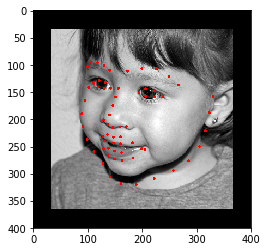

In [83]:
parameters.train_or_test = 'test'
parameters.demo = True
image_names_test_list = get_images_names(parameters)
bbox_dict = load_boxes(parameters)
n = 230
x1,t1,m1 = test_for_one_image(W_dict[24],image_names_test_list[n],bbox_dict[image_names_test_list[n]],initial_landmarks,parameters)

In [28]:
x1-initial_landmarks

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [ 0, -1],
       [ 0,  0],
       [ 0,  0],
       [ 0, -1],
       [ 0, -1],
       [ 0, -1],
       [ 0, -1],
       [ 0, -1],
       [ 0, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1,  0],
       [-1,  0],
       [-1, -1],
       [-1, -1],
       [-1, -1],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1, -1],
       [ 0,  0],
       [ 0,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [ 0,  0

helen/testset/imgs/3213087169_2.jpg


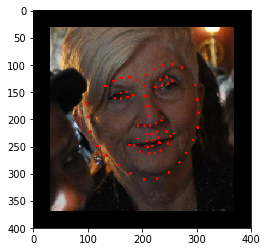

In [173]:
parameters.train_or_test = 'test'
parameters.demo = True
image_names_test_list = get_images_names(parameters)
bbox_dict = load_boxes(parameters)
n = 23
x1,t1,m14 = test_for_one_image(W4,image_names_test_list[n],bbox_dict[image_names_test_list[n]],initial_landmarks,parameters)

helen/trainset/imgs/2005566839_2.jpg


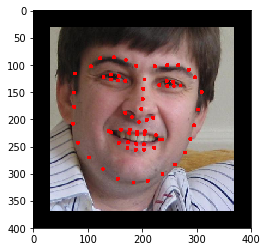

In [167]:
parameters.train_or_test = 'train'
parameters.demo = True
image_names_test_list = get_images_names(parameters)
bbox_dict = load_boxes(parameters)
n = 713
x1tr,t1tr,m1tr = test_for_one_image(W,image_names_test_list[n],bbox_dict[image_names_test_list[n]],initial_landmarks,parameters)

In [163]:
m1

[846.3676470588235,
 644.3235294117648,
 525.5735294117648,
 535.0,
 546.7647058823529]

In [168]:
m1tr

[72.98529411764706,
 7.970588235294118,
 7.367647058823529,
 4.102941176470588,
 2.485294117647059]

In [12]:
m1 # (32,32), alpha=1

[210.5, 207.0, 207.0, 207.0, 207.0]

In [18]:
m1 # (16,16), alpha=0.1

[378.38235294117646,
 328.1764705882353,
 330.2352941176471,
 332.11764705882354,
 332.4117647058824]

In [160]:
m #all images, alpha=1, (16,16)

[243.13235294117646,
 231.8235294117647,
 237.47058823529412,
 240.36764705882354,
 242.3235294117647]

In [48]:
x1-initial_landmarks


array([[-15,   7],
       [-13,   7],
       [-11,   7],
       [-10,   4],
       [ -9,  10],
       [-12,  13],
       [ -8,  18],
       [  3,  19],
       [ 11,  20],
       [ 17,  17],
       [ 18,  13],
       [ 13,   4],
       [  4,  -1],
       [ -5,  -5],
       [ -6,  -7],
       [ -5,  -6],
       [ -5,  -7],
       [ -8,  23],
       [ -9,   9],
       [  2,   0],
       [ 14,  -1],
       [ 23,   6],
       [ -1,   5],
       [  1,  -2],
       [  7,  -1],
       [ 10,   2],
       [  6,  12],
       [  8,   1],
       [ 10,   1],
       [ 15,   1],
       [ 18,   2],
       [  7,   1],
       [  9,   2],
       [ 12,   4],
       [ 16,   0],
       [ 15,  -6],
       [ -5,   8],
       [ -2,   7],
       [ -1,   7],
       [ -1,   5],
       [ -3,   5],
       [ -3,   6],
       [  2,  -2],
       [  4,  -1],
       [  2,  -3],
       [  2,  -3],
       [  3,  -5],
       [  4,  -5],
       [  6,   3],
       [  7,   5],
       [ 10,   6],
       [ 11,   6],
       [ 13,

In [63]:
W

array([[[-9.02026763e+00, -6.86306487e+00, -4.35011097e+00, ...,
         -5.08487383e+00, -2.37794183e+00, -6.77789413e+00],
        [ 2.07157034e+00,  1.28458351e+01,  3.62817212e+00, ...,
         -2.05794303e+01,  1.97890579e+01, -1.70635033e+01],
        [-3.76406510e+00, -1.40955710e+01, -1.05633022e+01, ...,
          1.64619413e+01, -1.79273228e+01,  1.06642379e+01],
        ...,
        [ 7.93611129e+00, -8.20822058e+00,  7.29396653e+00, ...,
         -2.90349640e+01, -4.47840185e+00, -3.02472525e+01],
        [-1.94643767e+00,  1.19481843e+01, -5.28862425e+00, ...,
          9.63273275e+00, -8.11140531e+00,  6.04841379e+00],
        [ 1.64536723e+01, -2.27625407e+00,  2.13661470e+01, ...,
          1.37559366e+01, -6.45874962e+00,  1.31654118e+01]],

       [[ 4.09878165e-05, -1.05433097e-04,  2.73146180e-05, ...,
         -8.37915772e-05, -5.39695600e-05, -1.01140936e-04],
        [-7.33372304e-05, -5.21223524e-05, -5.67984303e-05, ...,
          3.79064150e-05, -1.03845393e

In [17]:
x_k1 = x_k + np.matmul(HOG_x_k, W_k)

In [23]:
sio.savemat('train_data_32',{'W':W,'I':initial_landmarks})

In [35]:
image = cv.imread("helen/trainset/imgs/2560341685_1.jpg",0)
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
#compute(img[, winStride[, padding[, locations]]]) -> descriptors
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)
hist = hog.compute(image,winStride,padding,locations)
print(hist.shape)

(1764, 1)


68


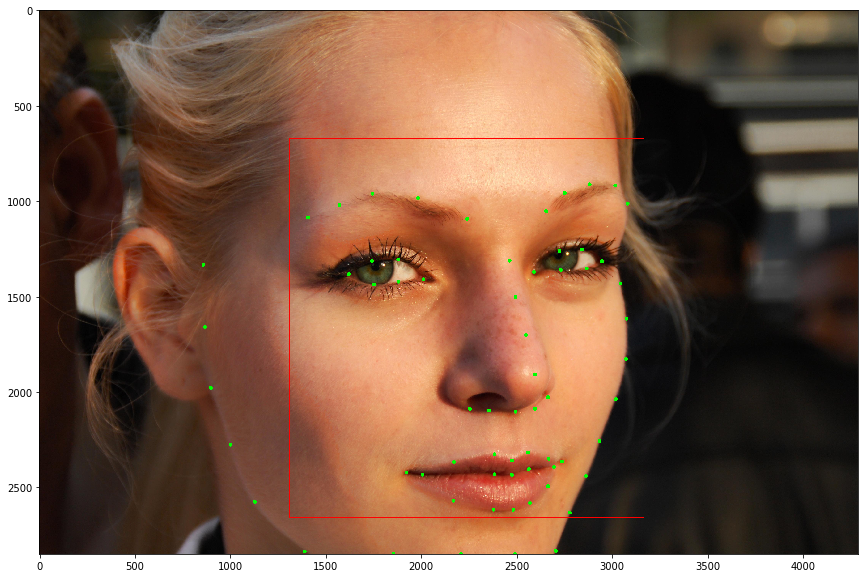

In [45]:
plt.figure(figsize=(20,10))
# face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
# face_cascade.load('/home/noa_raindel/.TF_cpu_new/lib/python3.5/site-packages/cv2/data/haarcascade_frontalface_default.xml')
img = cv.imread('helen/trainset/imgs/233470867_1.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

parameters.train_or_test = 'train'
ret = load_boxes(parameters)    
x0, y0, x1, y1 = ret['233470867_1.jpg']
cv.rectangle(img,(int(x0),int(y0)),(int(x1),int(y1)),(255,0,0),2)



a = load_landmarks('233470867_1.jpg', parameters)
print(len(a))
for landmark in a:
    landmark = [int(i) for i in landmark]
    cv.circle(img,tuple(landmark), 10, (0,255,0), -1)
# gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# for (x,y,w,h) in faces:

#     roi_gray = gray[y:y+h, x:x+w]
#     roi_color = img[y:y+h, x:x+w]
#     print(x,y,w,h)
# #     eyes = eye_cascade.detectMultiScale(roi_gray)
# #     for (ex,ey,ew,eh) in eyes:
# #         cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.imshow(img)

# cv.imshow('img',img)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [64]:
parameters = model_parameters()
hog_list = hog1(grey,mark,parameters)
len(hog_list)

1088

In [61]:
class model_parameters(object):
    
    def __init__(self,
                 N=3,
                 alpha=0.001,
                 new_size=(400,400),
                 expand=50,
                 expand_rate=0.25,
                 orientations=4,
                 pixels_per_cell=3,
                 cells_per_block=2,
                 cells_per_side=1,
                 train_or_test='train',
                 hog_no_block=True,
                 demo=False):
        self.N = N
        self.alpha = alpha
        self.new_size=new_size
        self.expand =expand
        self.expand_rate = expand_rate
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.cells_per_side = cells_per_side
        self.train_or_test = train_or_test
        self.hog_no_block = hog_no_block
        self.demo = demo
        
    def show_parameters(self):
        print('use data in trainset or testset:',self.train_or_test)
        print('the number of iterations:',self.N)
        print('the L1 regularization parameter alpha is:',self.alpha)
        print('the new image size used is:',self.new_size)
        print('how much to expand in data preparation:',self.expand)
        print('the rate of expand in modifing the bbox:',self.expand_rate)
        print('the number of divisions of gradient angle used by hog:',self.orientations)
        print('pixels per cell in hog descriptor:',self.pixels_per_cell)
        print('cells per side in hog decriptor:',self.cells_per_side)
        print('cells per bolck in hog descriptor:',self.cells_per_block)
        print('do not use the block when computing the hog:',self.hog_no_block)

In [19]:
def load_boxes(parameters):
# just some ugly translations from the very nested MATLAB representation of the bbox information
    bboxes1 = sio.loadmat('helen/bounding_boxes_helen_'+parameters.train_or_test +'set.mat')['bounding_boxes']
#     bboxes2 = sio.loadmat('300W/BoundingBoxes/bounding_boxes_helen_testset.mat')['bounding_boxes']
    ret = {}
    for bb in bboxes1[0]:
        ret[bb[0][0][0][0]] = list(bb[0][0][1][0])
#     for bb in bboxes2[0]:
#         ret[bb[0][0][0][0]] = list(bb[0][0][1][0])
    return ret

In [26]:
ret = get_bboxes()
ret['18489332_2.jpg']

[484.5261131926452, 226.84314645699237, 700.422652890084, 442.7396861544312]

In [20]:
def train(parameters):
    
    '''
    the standard SDM training function
    ---------------------------------------------------------------------------
    INPUT:
        parameters: the model parameter object
    OUTPUT:
        R: a numpy array of R
        b: a numpy array of b
        initials: a numpy array containing a initial landmarks (without ravel)
    ---------------------------------------------------------------------------
    '''
    parameters.train_or_test = 'train'
    
    #show the parameters which will be used
    parameters.show_parameters()
    
    #get the image path list
    image_path_list = get_image_path_list(parameters)
    
    #get the ground truth bounding boxes
    bbox_dict = load_boxes(parameters)
    
    #compute the hog features of ture landmarks
    mark_list = []
    hog_list = []
    grey_list = []
    print('computing the hog features for ture landmarks...........')
    for path in image_path_list:
        grey,mark = crop_and_resize_image(path,bbox_dict[path],parameters)
        hog_list.append(hog(grey,mark,parameters))
        grey_list.append(grey)
        mark_list.append(mark.ravel())
        
    HOG_TRUE = np.array(hog_list)
    MARK_TRUE = np.array(mark_list)
    
    #compute the initial landmarks by mean
    initials = np.mean(MARK_TRUE,axis = 0).astype(int)
    MARK_x = np.array([initials.tolist()] * len(image_path_list))
    initials = initials.reshape(68,2)
    
    #training
    R = []
    b = []
    
    for i in range(parameters.N):
        
        print('Iteration: ',i + 1)
        
        #compute the delta x
        MARK_delta = MARK_TRUE - MARK_x
        
        #compute the hog features
        HOG_x = np.zeros_like(HOG_TRUE)
        for j in range(len(image_path_list)):
            if j+1 % 100 == 0: print('already computed',j+1,'features')
            HOG_x[j,:] = hog(grey_list[j],MARK_x[j,:].reshape(68,2),parameters)
        
        #linear regression
        if parameters.alpha == 0:
            reg = LinearRegression(fit_intercept=False)
        else:
            reg = Lasso(alpha=parameters.alpha)
        print('computing the lasso linear regression.......')
        reg.fit(HOG_x,MARK_delta)  
        R.append(reg.coef_.T)
        b.append(reg.intercept_.T)
        
        #compute the sparse rate
        sparse_rate = R[-1][R[-1]==0].size / R[-1].size
        print('the sparse rate of',i+1,'th R is:',sparse_rate        )
        
        #compute new landmarks        
        MARK_x = MARK_x + np.matmul(HOG_x, R[i]) + b[i]
    
    R = np.array(R)
    b = np.array(b)
    sio.savemat('train_data',{'R':R,'B':b,'I':initials})
    
    return R,b,initials

In [83]:
def get_image_path_list(parameters):
    '''
    get a list containing all the paths of images in the trainset
    ---------------------------------------------------------------------------
    INPUT:
        parameters: model parameter object
    OUTPUT:
        a list with all the images' paths
    ---------------------------------------------------------------------------
    '''
#     folder_path = 'data/' + parameters.train_or_test + 'set/png'
    folder_path = 'helen/' + parameters.train_or_test + 'set/imgs'
    assert os.path.exists(folder_path)
    assert os.path.isdir(folder_path)
    print('already get all the image path.')
#     filesList = os.listdir(folder_path)
#     filesList = [x[:-4] for x in filesList]
    imageNames = os.listdir(folder_path)
    return imageNames[:300]



In [67]:
get_image_path_list(parameters)

already get all the image path.


['3532475790_1',
 '237815567_1',
 '4538917191_16',
 '5083671561_6',
 '4082680322_1',
 '1648807314_1',
 '2120936774_2',
 '4022732812_2',
 '3464901851_1',
 '253915276_1',
 '2406586388_2',
 '4009440741_2',
 '3346359383_3',
 '3020248483_1',
 '4250120238_1',
 '347826333_2',
 '2392075438_2',
 '2239710476_1',
 '4285163979_9',
 '5106695994_2',
 '347629355_2',
 '2030653815_1',
 '2803423910_1',
 '2086996835_5',
 '2863107962_1',
 '4145388945_2',
 '3729198156_2',
 '59354095_2',
 '4538917191_4',
 '2329110240_2',
 '4237203680_2',
 '5106695994_3',
 '4239974048_1',
 '3089202157_2',
 '4009440741_1',
 '111076519_1',
 '3576294411_2',
 '88094323_1',
 '213654866_1',
 '4285163979_8',
 '2312639559_1',
 '47618649_1',
 '281972218_1',
 '823016568_2',
 '2086996835_2',
 '4141887018_1',
 '1587030290_1',
 '5452623_1',
 '2099639490_1',
 '18489332_5',
 '1814664578_2',
 '4555082379_1',
 '4285163979_4',
 '5204730083_4',
 '5020454673_1',
 '4758145781_2',
 '156474078_1',
 '45092961_1',
 '3684472818_1',
 '2339510439_2',
 

In [ ]:
# def load_boxes(parameters):
#     '''
#     load the ground truth ground truth boxes coordinates from .mat file
#     ---------------------------------------------------------------------------
#     INPUT:
#         parameters: model parameter object
#     OUTPUT:
#         a dict with all the ground truth bounding boxes coordinates
#         key: a string of filename    ex: 'image_0122.png'
#         value: a numpy array of boungding boxes
#     ---------------------------------------------------------------------------
#     '''
#     file_path = 'data/bounding_boxes/bounding_boxes_lfpw_' + parameters.train_or_test + 'set.mat'
#     assert os.path.exists(file_path)
#     x = sio.loadmat(file_path)['bounding_boxes'][0]
#     x = [x[0][0] for x in x]
#     print('loading ground truth bboxes....................')
#     return {x[i][0][0]:x[i][1][0] for i in range(len(x))}

In [23]:
def load_landmarks(image_name,parameters):
    '''
    load the landmarks coordinates from .pts file
    ---------------------------------------------------------------------------
    INPUT:
        image_name: a string without extension   ex: 'image_0122'
        parameters: model parameter object
    OUTPUT:
        a numpy array containing all the points
    ---------------------------------------------------------------------------
    '''   
#     file_path = 'data/' + parameters.train_or_test + 'set/pts/' + image_name + '.pts'  
    file_path = 'helen/' + parameters.train_or_test + 'set/pts/' + image_name[:-4] +'.pts'  
    assert os.path.exists(file_path)
    with open(file_path) as f: rows = [rows.strip() for rows in f]
    coords_set = [point.split() for point in rows[rows.index('{') + 1:rows.index('}')]]
    return np.array([list([float(point) for point in coords]) for coords in coords_set])

In [24]:
def compute_new_bbox(image_size,bbox,parameters):
    '''
    compute the expanded bbox
    a robust function to expand the crop image bbox even the original bbox is
    around the border of the image
    ---------------------------------------------------------------------------
    INPUT:
        image_size: a tuple   ex: (height,width)
        bbox: the ground_truth bounding boxes  ex:[x0,y0,x1,y1]
        parameters: model parameter object
    OUTPUT:
        new bbox: ex:[x0,y0,x1,y1]
    ---------------------------------------------------------------------------
    '''
    x_size,y_size = image_size
    bx0,by0,bx1,by1 = bbox
    bw = by1 - by0
    bh = bx1 - bx0
    if bw > bh:
        delta = parameters.expand_rate * bw
        if by1 + delta > y_size:
            nby1 = y_size
        else:
            nby1 = int(floor(by1 + delta))
        if by0 - delta < 0:
            nby0 = 0
        else:
            nby0 = int(floor(by0 - delta))
        new_w = nby1 - nby0
        delta_h = (new_w - bh) / 2
        if bx0 - delta_h < 0:
            nbx0 = 0
        else:
            nbx0 = int(floor(bx0 - delta_h))
        if bx1 + delta_h > x_size:
            nbx1 = x_size
        else:
            nbx1 = int(floor(bx1 + delta_h))
    else:
        delta = parameters.expand_rate * bh
        if bx1 + delta > x_size:
            nbx1 = x_size
        else:
            nbx1 = int(floor(bx1 + delta))
        if bx0 - delta < 0:
            nbx0 = 0
        else:
            nbx0 = int(floor(bx0 - delta))
        new_h = nbx1 - nbx0
        delta_w = (new_h - bw) / 2
        if by0 - delta_w < 0:
            nby0 = 0
        else:
            nby0 = int(floor(by0 - delta_w))
        if by1 + delta_w > y_size:
            nby1 = y_size
        else:
            nby1 = int(floor(by1 + delta_w))
    return nbx0,nby0,nbx1,nby1

In [72]:
def crop_and_resize_image(image_name,bbox,parameters):
    '''
    crop and resize the image given the ground truth bounding boxes
    also, compute the new coordinates according to transformation
    ---------------------------------------------------------------------------
    INPUT:
        image_name: a string without extension  ex: 'image_0007'
        bbox: the ground_truth bounding boxes  ex:[x0,y0,x1,y1]
        parameters: model parameter object
    OUTPUT:
        grey: a numpy array of grey image after crop and resize
        landmarks: new landmarks accordance with new image
    ---------------------------------------------------------------------------
    '''
#     image_path = 'data/' + parameters.train_or_test + 'set/png/' + image_name + '.png'
    image_path = 'helen/' + parameters.train_or_test + 'set/imgs/' + image_name # + '.jpg'
    print(image_path)
    assert os.path.exists(image_path)
    im = Image.open(image_path)
    bbox = compute_new_bbox(im.size,bbox,parameters)
    im_crop = im.crop(bbox)
    Expand = parameters.expand
    im_expand = ImageOps.expand(im_crop,(Expand,Expand,Expand,Expand),fill = 'black')
    im_resize = im_expand.resize(parameters.new_size)
    grey = im_resize.convert('L')
    
    #compute the new landmarks according to transformation procedure
    landmarks = load_landmarks(image_name,parameters)
#     print(bbox[:2])
#     print('*****')
#     print(bbox)
#     print('*****')
#     print(landmarks)
#     print('*****')
    
    landmarks = landmarks - (bbox[:2]) + Expand
    landmarks = landmarks * im_resize.size / im_expand.size
    
    return np.array(grey),landmarks.astype(int)

In [63]:
def hog1(image, xys, parameters):
    '''
    Given a grey image in numpy array and a vector of sequence of coordinates,
    return the ndarray of hog feature vectors extract from given locations
    ---------------------------------------------------------------------------
    INPUT:
        image: grey image, numpy array, 8-bit
        xys: coordinates, numpy array, float
        parameters: model parameter object
    OUTPUT:
        features: ndarray of all the features extracted from locations in xy
    ---------------------------------------------------------------------------
    '''
    image = np.atleast_2d(image)    
    if image.ndim > 3: raise ValueError("Currently only supports grey-level images")


    #normalisation
    image = sqrt(image)
    
    
    #compute the gradients of the input grey image
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1)
    gy[:-1, :] = np.diff(image, n=1, axis=0)
    
    
    #compute the magnitude and orientation of gradients
    magnitude = sqrt(gx ** 2 + gy ** 2)
    orientation = arctan2(gy, (gx + 1e-15)) * (180 / pi) + 180

    #just for convinients, make the variables shorter
    r = parameters.pixels_per_cell * parameters.cells_per_side
    pc = parameters.pixels_per_cell
    eps = 1e-5
    
    #compute the orientation histogram
    orientation_histogram = np.zeros((len(xys), 
                                      parameters.cells_per_side*2, 
                                      parameters.cells_per_side*2, 
                                      parameters.orientations))    
    for j in range(len(xys)):        
        x, y = xys[j].astype(int)
        for i in range(parameters.orientations):
            # classify the orientation of the gradients
            temp_ori = np.where(orientation <= 180 / parameters.orientations * (i + 1) * 2,
                                orientation, 0)
            temp_ori = np.where(orientation > 180 / parameters.orientations * i * 2,
                                temp_ori, 0)
            # select magnitudes for those orientations
            cond2 = temp_ori > 0
            temp_mag = np.where(cond2, magnitude, 0)

            orientation_histogram[j,:,:,i] = uniform_filter(temp_mag, size=pc)[int(x-r+pc/2):int(x+r):int(pc), int(y-r+pc/2):int(y+r):int(pc)].T
        
        if parameters.hog_no_block:
            orientation_histogram[j] /= sqrt(orientation_histogram[j].sum()**2 + eps)
    
    if parameters.hog_no_block: return orientation_histogram.ravel()
        
    
    #compute the block normalization
    n_blocks = parameters.cells_per_side * 2 - parameters.cells_per_block + 1
    cb = parameters.cells_per_block
    normalised_blocks = np.zeros((len(xys), n_blocks, n_blocks, cb, cb, parameters.orientations))
    
    for i in range(len(xys)):
        for x in range(n_blocks):
            for y in range(n_blocks):
                block = orientation_histogram[i,x:x + cb, y:y + cb, :]            
                normalised_blocks[i, x, y, :] = block / sqrt(block.sum() ** 2 + eps)
    
    return normalised_blocks.ravel()

In [111]:
if __name__ == '__main__':
    parameters = model_parameters()
    if os.path.exists('train_data.mat'):
        data = sio.loadmat('train_data.mat')
        R = data['R']
        B = data['B']
        I = data['I']
    else:
        R,B,I = train(parameters)
    parameters.train_or_test = 'test'
    image_path_list = get_image_path_list(parameters)
    bbox_dict = load_boxes(parameters)

already get all the image path.


In [115]:
def test_for_one_image(R,b,path,bbox,initials,parameters):
    '''
    given the regressors, predicted the landmarks
    ---------------------------------------------------------------------------
    INPUT:
        R: the R matrix
        b: the b vector
        path: the image file name with extension
        bbox: the numpy array of bbox
        initials: the numpy array of initials landmarks
        parameters: model parameter object
    OUTPUT:
        mark_x: predicted landmarks
        mark_t: the true landmarks
        MSE: the mean square error of all the iterations
    ---------------------------------------------------------------------------
    '''
    parameters.train_or_test = 'test'                       
                           
    grey,mark_true = crop_and_resize_image(path,bbox,parameters)
    mark_x = initials.astype(int)
    MSE = []
    
    for i in range(R.shape[0]):
        hog_x = hog(grey,mark_x,parameters)
        mark_x = (mark_x.ravel() + np.matmul(hog_x,R[i]).astype(float) + b[i].astype(float)).reshape(68,2)
        RMSE.append(sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
        
    if parameters.demo:
        im = Image.fromarray(grey)
        draw = ImageDraw.Draw(im)
        width = 5
        for i in range(len(mark_x)):
            circle = [mark_x[i,0]-width,mark_x[i,1]-width,mark_x[i,0]+width,mark_x[i,1]+width]
            draw.ellipse(circle,fill = 'red')
    
        plt.imshow(im, cmap='gray')
    
        
    return mark_x.astype(int),mark_true,RMSE

In [116]:
def test_after_run_main(n):
    x,t,m = test_for_one_image(R,B,image_path_list[n],bbox_dict[image_path_list[n]],I,parameters)
    return x,t,m

In [118]:
###### parameters.demo = True
x,t,m = test_after_run_main(34)
x1,t1,m1 = test_after_run_main(102)
print(x)
print('****')
print(x1)
print('****')
print(x-I)
# img = cv.imread('helen/testset/imgs/3220050079_2.jpg')
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# parameters.train_or_test = 'test'
# ret = load_boxes(parameters)    
# x0, y0, x1, y1 = ret['2993039649_1.jpg']
# cv.rectangle(img,(int(x0),int(y0)),(int(x1),int(y1)),(255,0,0),2)



# for landmark in t:
#     landmark = [int(i) for i in landmark]
#     cv.circle(img,tuple([landmark[0] + int(x0), landmark[1]+int(y0)]), 10, (0,255,0), -1)
# for landmark in x:
#     landmark = [int(i) for i in landmark]
#     cv.circle(img,tuple([landmark[0] + int(x0), landmark[1]+int(y0)]), 10, (0,0,255), -1)
#     # gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# # faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# # for (x,y,w,h) in faces:

# #     roi_gray = gray[y:y+h, x:x+w]
# #     roi_color = img[y:y+h, x:x+w]
# #     print(x,y,w,h)
# # #     eyes = eye_cascade.detectMultiScale(roi_gray)
# # #     for (ex,ey,ew,eh) in eyes:
# # #         cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
# plt.imshow(img)

helen/testset/imgs/3029583859_1.jpg
helen/testset/imgs/3187466455_1.jpg
[[ 62 142]
 [ 74 187]
 [ 78 223]
 [ 91 243]
 [109 258]
 [123 265]
 [144 282]
 [180 291]
 [226 272]
 [262 275]
 [280 271]
 [301 258]
 [322 246]
 [333 223]
 [335 194]
 [339 148]
 [331  99]
 [ 75 104]
 [ 87  95]
 [110  82]
 [142  71]
 [190  69]
 [212  52]
 [252  55]
 [284  58]
 [312  73]
 [341  78]
 [207 102]
 [205 124]
 [204 141]
 [195 157]
 [162 175]
 [177 176]
 [179 176]
 [187 171]
 [208 171]
 [102 133]
 [115 129]
 [131 117]
 [160 118]
 [139 127]
 [124 137]
 [239 108]
 [263 107]
 [278 107]
 [280 110]
 [273 110]
 [262 110]
 [151 207]
 [166 202]
 [176 199]
 [184 204]
 [210 202]
 [233 202]
 [257 210]
 [243 224]
 [216 228]
 [185 226]
 [177 214]
 [163 224]
 [149 210]
 [174 205]
 [179 214]
 [213 213]
 [262 213]
 [213 214]
 [191 214]
 [179 209]]
****
[[ 92 129]
 [108 174]
 [109 208]
 [115 261]
 [145 301]
 [178 336]
 [203 350]
 [254 352]
 [284 358]
 [319 320]
 [315 298]
 [300 254]
 [313 233]
 [295 198]
 [292 174]
 [283 166

In [39]:
help(cv.HOGDescriptor)

Help on class HOGDescriptor in module cv2.cv2:

class HOGDescriptor(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  checkDetectorSize(...)
 |      checkDetectorSize() -> retval
 |      .   @brief Checks if detector size equal to descriptor size.
 |  
 |  compute(...)
 |      compute(img[, winStride[, padding[, locations]]]) -> descriptors
 |      .   @brief Computes HOG descriptors of given image.
 |      .   @param img Matrix of the type CV_8U containing an image where HOG features will be calculated.
 |      .   @param descriptors Matrix of the type CV_32F
 |      .   @param winStride Window stride. It must be a multiple of block stride.
 |      .   @param padding Padding
 |      .  

helen/trainset/imgs/233470867_1.jpg
(904, 176)
*****
(904, 176, 3576, 2848)
*****
[[ 860.949727 1333.878794]
 [ 868.641967 1659.35031 ]
 [ 899.081223 1978.758195]
 [1002.926696 2275.486493]
 [1129.804489 2574.773588]
 [1391.592594 2835.821225]
 [1856.327013 2848.      ]
 [2208.054234 2848.      ]
 [2492.551566 2848.      ]
 [2705.548103 2831.062201]
 [2778.893931 2631.086617]
 [2864.830552 2439.200868]
 [2934.953421 2256.501033]
 [3019.830364 2037.625557]
 [3073.413463 1826.185981]
 [3075.214307 1616.615232]
 [3045.669821 1432.098706]
 [1408.554404 1086.20539 ]
 [1573.98125  1021.853033]
 [1746.129793  962.687023]
 [1984.050646  984.197879]
 [2241.251176 1093.579158]
 [2655.126024 1053.52207 ]
 [2752.570611  957.159634]
 [2882.174035  913.417303]
 [3016.6319    918.290741]
 [3081.702257 1013.026303]
 [2463.189332 1311.913544]
 [2495.086097 1502.774618]
 [2550.327648 1701.340342]
 [2596.919566 1908.926755]
 [2255.787649 2088.692278]
 [2356.379842 2096.249711]
 [2495.604167 2103.995327]


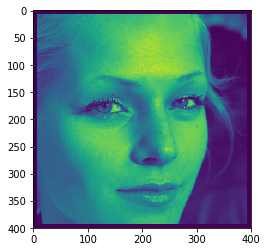

In [67]:
parameters = model_parameters()
path = '233470867_1.jpg'
bbox_dict = load_boxes(parameters)
grey,mark = crop_and_resize_image(path,bbox_dict[path],parameters)
print('marks')
print(mark)
# for landmark in mark:
#     landmark = [int(i) for i in landmark]
#     cv.circle(img,tuple(landmark), 10, (255,0,0), -1)
plt.imshow(grey)
print(hog(grey,mark,parameters))